In [117]:
import numpy as np
from CNNModel import CNNModel
from layers import Convolution, Flatten, MaxPool2D, Dense

In [ ]:
!git clone https://github.com/mhp128/Parallel-Image-Classification-using-CNN.git
!mv Parallel-Image-Classification-using-CNN/kernels.py kernels.py
!mv Parallel-Image-Classification-using-CNN/layers.py layers.py
!mv Parallel-Image-Classification-using-CNN/CNNModel.py CNNModel.py
!rm -r Parallel-Image-Classification-using-CNN

# CONVOLUTION

In [35]:
inputs=np.random.randint(1,255, (64,100, 100,3))/255
conv =Convolution(n_filters=32, filter_size=3, stride=1,activation='relu',input_shape=(100,100,3))

#### Forward test

In [36]:
%%time
#Use Deivce 
conv.use_device=True
outputs_host=conv.forward(inputs)

CPU times: user 78.1 ms, sys: 42 ms, total: 120 ms
Wall time: 122 ms


In [37]:
%%time
#Use Host
conv.use_device=False
outputs_device=conv.forward(inputs)

CPU times: user 2min 24s, sys: 423 ms, total: 2min 24s
Wall time: 2min 31s


In [38]:
print("Loss:",np.sum(np.abs(outputs_device-outputs_host)))

Loss: 5.094799774074953e-10


#### Backward test

In [41]:
%%time
conv.use_device=True
input_device=conv.backward(outputs_device,0.001)

CPU times: user 508 ms, sys: 0 ns, total: 508 ms
Wall time: 507 ms


In [42]:
%%time
conv.use_device=False
input_device=conv.backward(outputs_device,0.001)

CPU times: user 11min 52s, sys: 1.81 s, total: 11min 53s
Wall time: 12min 24s


# MAX POOLING


In [43]:
inputs=np.random.randint(1,255, (64,100, 100,32))/255
pool = MaxPool2D(input_shape=inputs.shape[1:])

#### Forward test

In [44]:
%%time
pool.use_device=False
out1= pool.forward(inputs)

CPU times: user 1.25 s, sys: 74.2 ms, total: 1.32 s
Wall time: 1.27 s


In [46]:
%%time 
pool.use_device=True
out=pool.forward(inputs)

CPU times: user 64.4 ms, sys: 16 ms, total: 80.4 ms
Wall time: 81.3 ms


#### Backward Test

In [47]:
%%time
pool.use_device=False
in_host=pool.backward(out1,0.001)

CPU times: user 3.87 s, sys: 412 ms, total: 4.28 s
Wall time: 4 s


In [49]:
%%time
pool.use_device=True
in_device=pool.backward(out1,0.001)

CPU times: user 78.2 ms, sys: 27 ms, total: 105 ms
Wall time: 104 ms


In [ ]:
print("Loss:",np.sum(np.abs(in_host-in_device)))

0.0

# Dense

In [60]:
inputs=np.random.randint(1,255, (256,10000))/255
dense=Dense(1024, input_shape= 10000)

#### Forward test

In [61]:
%%time
dense.use_device=True
out_device=dense.forward(inputs)

CPU times: user 151 ms, sys: 995 µs, total: 152 ms
Wall time: 156 ms


In [62]:
%%time
dense.use_device=False
out_host=dense.forward(inputs)

CPU times: user 269 ms, sys: 6.9 ms, total: 276 ms
Wall time: 144 ms


#### Backward test

In [58]:
# %%time
# dense.use_device=False
# in_host=dense.backward(out_device,0.01)

In [59]:
# %%time
# dense.use_device=True
# in_device=dense.backward(out_device,0.01)

# BUILD MODEL AND TRAINING ON DEVICE

In [63]:
from keras.datasets import mnist

In [113]:
(train_X, train_y), (test_X, test_y) = mnist.load_data()
y_train = np.zeros((len(train_y),10))
y_test = np.zeros((len(test_y),10))
for i in range (len(y_train)):
  y_train[i,train_y[i]]=1
for i in range (len(y_test)):
  y_test[i,test_y[i]]=1
x_train=train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)
x_test=test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)
x_train=x_train/255
x_test=x_test/255

In [89]:
model=CNNModel([ 
    Convolution(n_filters=16, filter_size=3, stride=1,activation='relu',input_shape=(28,28,1)),
    MaxPool2D(pool_size=2),
    Convolution(n_filters=32, filter_size=3, stride=1,activation='relu'),
    Flatten(),
    Dense(128),
    Dense(10, activation='softmax')
])
model.use_device(True)

In [90]:
%%time
model.fit(x_train,y_train, epochs=5, batch_size=128)


Epoch 1/5:
 469/469 [==============================] accuaray: 0.89795, train loss = 0.15327
Epoch 2/5:
 469/469 [==============================] accuaray: 0.95569, train loss = 0.06502
Epoch 3/5:
 469/469 [==============================] accuaray: 0.96460, train loss = 0.05177
Epoch 4/5:
 469/469 [==============================] accuaray: 0.96763, train loss = 0.04638
Epoch 5/5:
 469/469 [==============================] accuaray: 0.96292, train loss = 0.05367CPU times: user 3min 22s, sys: 2min 24s, total: 5min 47s
Wall time: 3min 20s


In [122]:
model.use_device(True)
%time y_predict_device =model.predict(x_test)

CPU times: user 2.07 s, sys: 298 ms, total: 2.37 s
Wall time: 2.36 s


In [123]:
model.use_device(False)
%time y_predict_host =model.predict(x_test)

CPU times: user 17min 2s, sys: 3.46 s, total: 17min 5s
Wall time: 17min 9s


In [124]:
print("Loss",np.mean(np.abs(y_predict_device - y_predict_host)))

Loss 1.101404419095218e-17


In [125]:
accuracy=np.mean(np.argmax(y_predict_device,axis=1) ==  test_y)
print("Accuracy",accuracy)

Accuracy 0.9574


In [118]:
import matplotlib.pyplot as plt

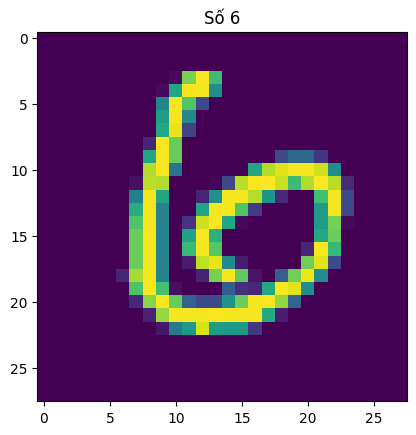

In [121]:
n=11
plt.title(f'Số {np.argmax(y_predict_device[n])}')
plt.imshow(x_test[n])
plt.show()